# CLUSTERING

In v2 the voltage categories are reduced so the total number of clusters including all dimensions (overvoltages, undervoltages and overloadings) are small in number (close to 10).
Also for each cluster three points are selected: the two extremes(min and max) and the middle point. This choice is based by projecting all the points on a line using a weight function eg:
f1/3 + f2/3 + f3/3, where f1,f2,f3 can be the values of overvoltage, undervoltage and overloading on that day.

Two representative buses are choses as a reference for the overvoltage and undervoltages respectively. Finally the overloading value is based on the ilo index which accounts for the total overloading of all lines in one day.
However I will probably change the first part so that instead of depending only on the chosen representative buses, instead all the buses of the network will be taken into account to categorize the voltage violations on each day. That can be done by just calculating the min and max of all buses in the network for a day.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import json
import tempfile
import matplotlib.pyplot as plt
import pandapower as pp
from multi_year_utils import *

In [2]:
CURRENT_SCENARIO = '2_bau'
INVESTMENT_YEAR = 6
FINAL_LOAD_GROWTH_YEAR = 11
FINAL_YEAR = 15

In [3]:
DAY_CATEGORIES_NAMES = ["normal", "limited-ov/uv", "ov", "ov + ol", "uv", "uv + ol", "ov + uv", "ov + uv + ol",  "rest"]

TIMESTEPS = 35040 # 365 days with 15min resolution
V_REF = 1.0 # pu
V_NOM = 416 # V

# Define Voltage Deviation Limits
SOFT_VOLT_LIMIT  = 0.05 * V_NOM
UPPER_VOLT_LIMIT  = 0.10 * V_NOM

In [4]:
working_folder = os.getcwd()
root_dir = os.path.abspath(os.path.join(working_folder, os.pardir))
root_dir = os.path.abspath(os.path.join(root_dir, os.pardir))
network_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO,'network')
data_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO)
output_dir = os.path.join(tempfile.gettempdir(), "time_series")

# load required dataframes
# aggregate node consumption/generation data
aggregate_node_data = pd.read_csv(os.path.join(data_path,"aggregate_node_info.csv"))
generators_df = pd.read_csv(os.path.join(data_path,"pv_data","pv_info.csv"))

# Output cluster data
clusters_df = pd.DataFrame(columns =['year', 'id', 'type', 'f_value'])
# Representative days cluster dictionary
rep_days_data = {}

In [5]:
final_load_growth_year_is_solved = False
last_year_date_categories = {}
last_year_results = {}
last_year_combined_values = []

for year in range(INVESTMENT_YEAR, FINAL_YEAR + 1):
    # load network
    net = pp.from_json(os.path.join(network_path,'IEEE_modified_LV_Feeder.json'))
    
    if year < FINAL_LOAD_GROWTH_YEAR:
        timeseries_calculation(net, TIMESTEPS, year, output_dir, aggregate_node_data, generators_df, data_path)
        bus_voltage_data_array, line_loading_data_array = load_time_series_results(output_dir, V_NOM)
        day_categories, ovs, uvs, ilo_all_lines_daily = create_clusters(bus_voltage_data_array, line_loading_data_array, DAY_CATEGORIES_NAMES, V_NOM, SOFT_VOLT_LIMIT, UPPER_VOLT_LIMIT)
        combined_values, results = get_representative_days(ovs, uvs, ilo_all_lines_daily, day_categories)
        rep_days_data[year] = results
        clusters_df = update_cluster_dataframe(clusters_df, year, combined_values, day_categories)
    elif year >= FINAL_LOAD_GROWTH_YEAR and not final_load_growth_year_is_solved:
        timeseries_calculation(net, TIMESTEPS, year, output_dir, aggregate_node_data, generators_df, data_path)
        bus_voltage_data_array, line_loading_data_array = load_time_series_results(output_dir, V_NOM)
        day_categories, ovs, uvs, ilo_all_lines_daily = create_clusters(bus_voltage_data_array, line_loading_data_array, DAY_CATEGORIES_NAMES, V_NOM, SOFT_VOLT_LIMIT, UPPER_VOLT_LIMIT)
        combined_values, results = get_representative_days(ovs, uvs, ilo_all_lines_daily, day_categories)
        rep_days_data[year] = results
        clusters_df = update_cluster_dataframe(clusters_df, year, combined_values, day_categories)

        # update the last year data
        final_load_growth_year_is_solved = True
        last_year_date_categories = day_categories
        last_year_results = results
        last_year_combined_values = combined_values
    else:
        rep_days_data[year] = last_year_results
        clusters_df = update_cluster_dataframe(clusters_df, year, last_year_combined_values, last_year_date_categories)

c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profiles[row['load_name'] + '_P'] = np.add(load_profile, ev_profile)
c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profiles[row['load_name'] + '_Q'] = 0
c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:30: Performa

In [6]:
# Save cluster data to csv file
clusters_df.to_csv(os.path.join(data_path, 'clusters.csv'), index=False)  # Set index=False to not save row indices

# Save representative days data to json file:
output_json_file = os.path.join(data_path, 'clusters_representative.json')

with open(output_json_file, 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(rep_days_data, f, indent=4)

### Debug the code

In [7]:
# Sum the days of all the years(total days to run in the optimization)
def sum_final_values(data, year_start, year_end):
    total_sum = 0
    for key, value in data.items():
        if year_start <= int(key) <= year_end:
            for sub_key, sub_value in value.items():
                if isinstance(sub_value, list):
                    total_sum += len(sub_value)
    return total_sum

In [16]:
with open(os.path.join(data_path, 'clusters_representative.json'), 'r') as file:
    rep_days_data = json.load(file)

rep_days_data['10']

{'ov': [239, 210, 262, 143, 112],
 'ov + ol': [],
 'uv': [29, 11, 14, 71, 267],
 'uv + ol': [291, 316],
 'ov + uv': [243, 279, 130, 110],
 'ov + uv + ol': [92],
 'rest': []}

In [18]:
sum_final_values(rep_days_data, 9, 10)

41

In [51]:
bus_voltage_data_array, line_loading_data_array = load_time_series_results(output_dir, V_NOM)

In [53]:
day_categories, ovs, uvs, ilo_all_lines_daily = create_clusters(bus_voltage_data_array, line_loading_data_array, DAY_CATEGORIES_NAMES, V_NOM, SOFT_VOLT_LIMIT, UPPER_VOLT_LIMIT)

In [83]:
combined_values, results = get_representative_days(ovs, uvs, ilo_all_lines_daily, day_categories)

### Plot Day Grouppings into Clusters

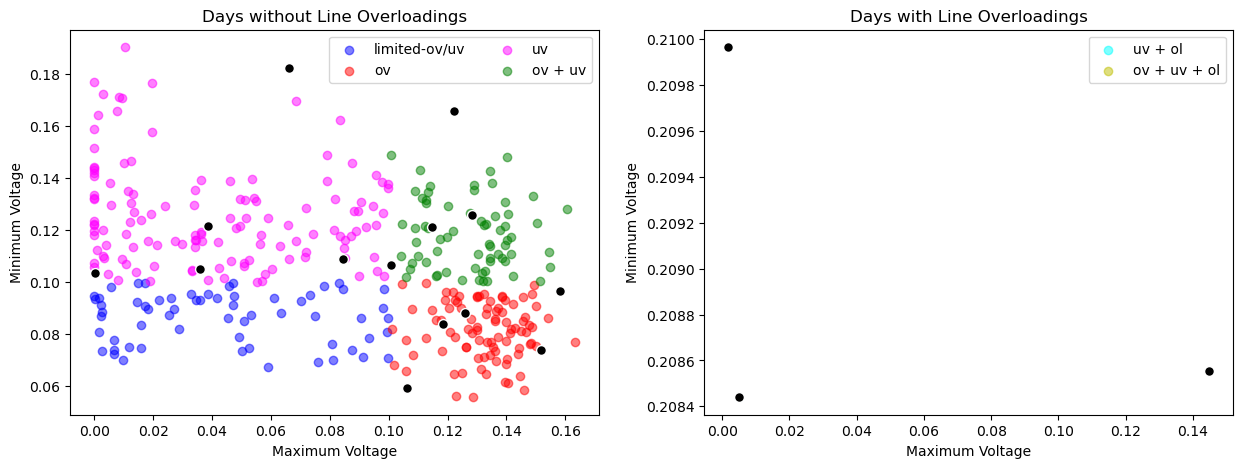

In [19]:
# Define the color mapping for each category
category_colors = {
    "normal": "grey",
    "limited-ov/uv": "blue",
    "ov + ol": "b",
    "ov": "red",
    "uv + ol": "cyan",
    "uv": "magenta",
    "ov + uv + ol": "y",
    "ov + uv": "g",
    "rest": "orange"
}

# Get the index of days with overloading
days_with_overloading_ind = np.where(ilo_all_lines_daily > 0)[0]
days_with_overloading = set(days_with_overloading_ind + 1)

# Create two scatter plots side by side
plt.figure(figsize=(15, 5))

# Plot for days without overloading
plt.subplot(1, 2, 1)
plt.title('Days without Line Overloadings')
plt.xlabel('Maximum Voltage')
plt.ylabel('Minimum Voltage')
for category, days in day_categories.items():
    # Filter days without overloading
    days_no_overload = [day-1 for day in days if day not in days_with_overloading]
    if days_no_overload:
        plt.scatter(ovs[days_no_overload]/416, uvs[days_no_overload]/416, alpha=0.5, label=category, color=category_colors[category])

# Plot special points from results dictionary in black for days without overloading
for category, special_days in results.items():
    special_days_no_overload = [day-1 for day in special_days if day not in days_with_overloading]
    if special_days_no_overload:
        plt.scatter(ovs[special_days_no_overload]/416, uvs[special_days_no_overload]/416, color='black', edgecolor='white', s=50)

plt.legend(loc='upper right', ncol=2)

# Plot for days with overloading
plt.subplot(1, 2, 2)
plt.title('Days with Line Overloadings')
plt.xlabel('Maximum Voltage')
plt.ylabel('Minimum Voltage')
for category, days in day_categories.items():
    # Filter days with overloading
    days_with_overload = [day-1 for day in days if day in days_with_overloading]
    if days_with_overload:
        plt.scatter(ovs[days_with_overload]/416, uvs[days_with_overload]/416, alpha=0.5, label=category, color=category_colors[category])

# Plot special points from results dictionary in black for days with overloading
for category, special_days in results.items():
    special_days_with_overload = [day-1 for day in special_days if day in days_with_overloading]
    if special_days_with_overload:
        plt.scatter(ovs[special_days_with_overload]/416, uvs[special_days_with_overload]/416, color='black', edgecolor='white', s=50)

plt.legend(loc='upper right')

plt.show()

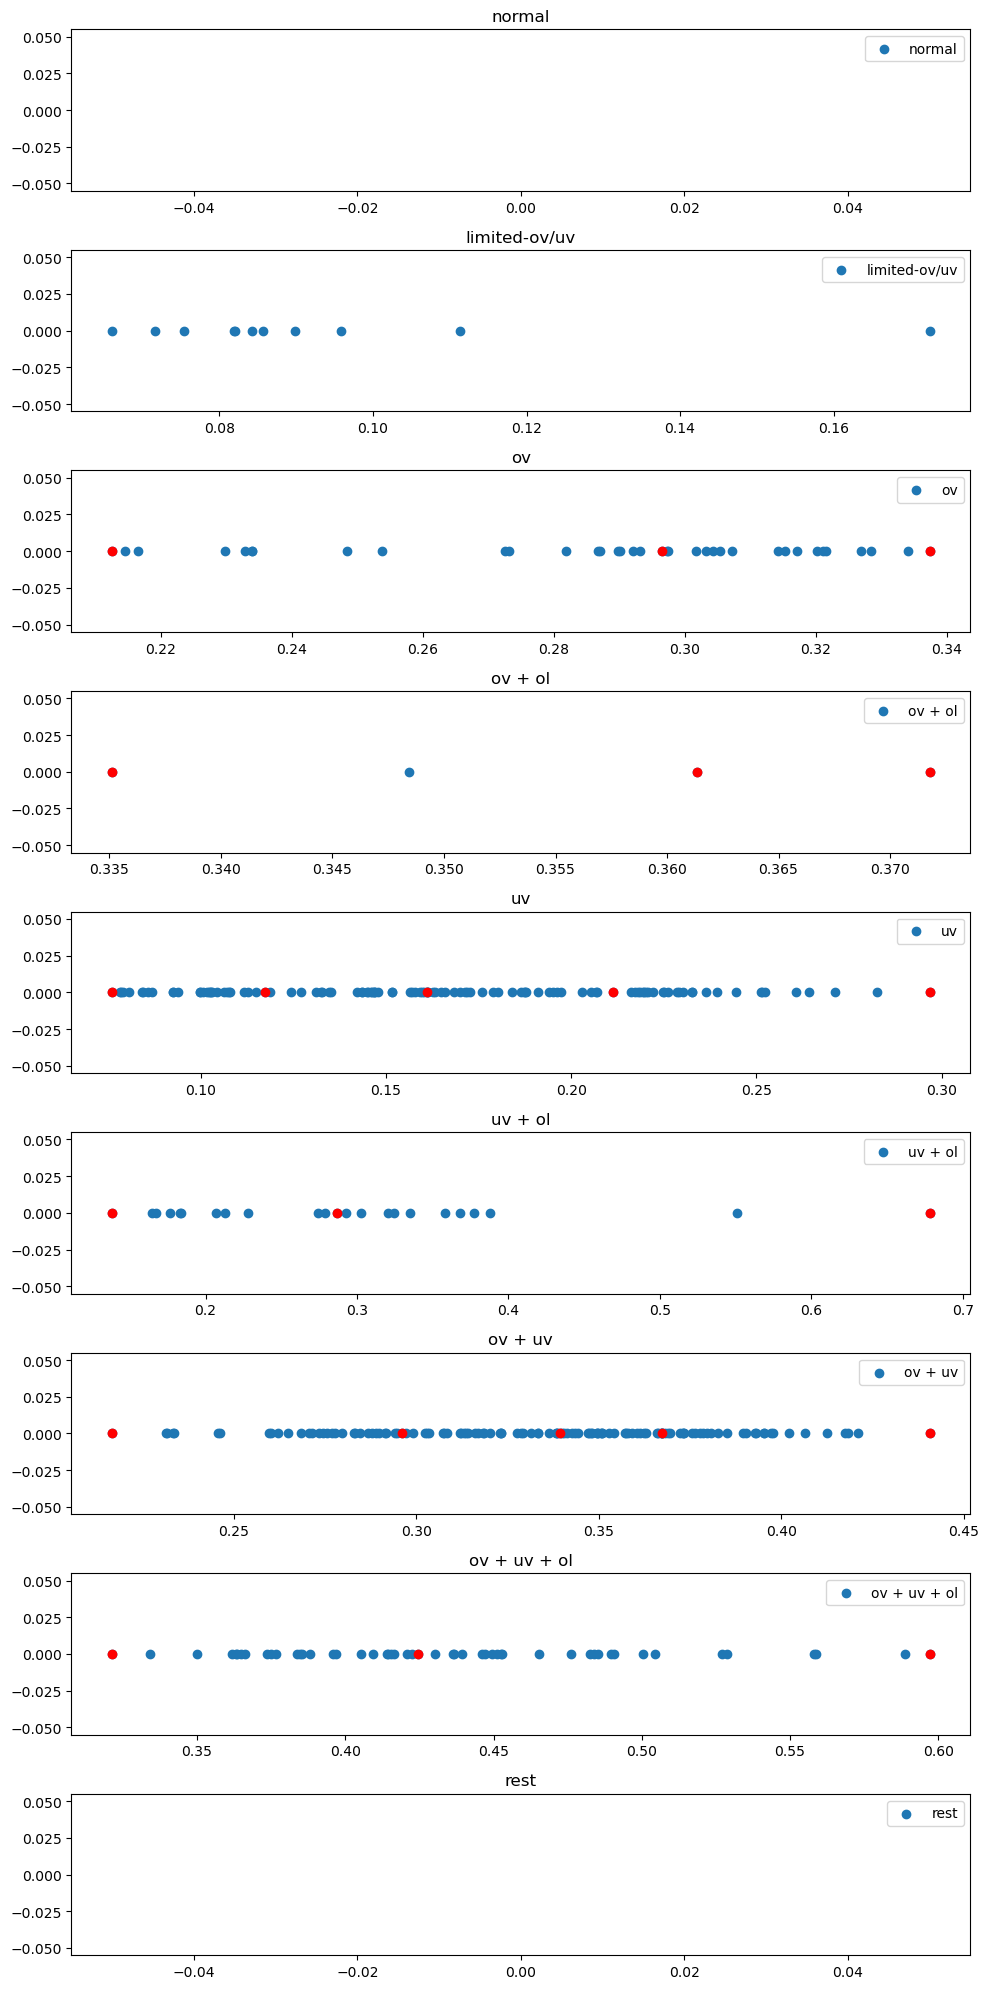

In [90]:
# Plotting
fig, axes = plt.subplots(len(DAY_CATEGORIES_NAMES), 1, figsize=(10, 20))

for idx, category in enumerate(DAY_CATEGORIES_NAMES):
    days = day_categories[category]
    values = [combined_values[day - 1] for day in days]
    
    axes[idx].scatter(values, [0] * len(values), label=category)
    
    # Highlight the days that are in the results dictionary
    if category in results:
        highlight_days = results[category]
        highlight_values = [combined_values[day - 1] for day in highlight_days]
        axes[idx].scatter(highlight_values, [0] * len(highlight_values), color='red', zorder=5)
    
    axes[idx].set_title(category)
    axes[idx].legend()

plt.tight_layout()
plt.show()